This example aims to have two target orbits, and one observer orbit. The observer is tasked with monitoring the two targets to minimize the trace covariance of the state over the simulation horizon. We use a PPO agent that is rewarded for minimizing the trace covariance of the target states to the best of its ability.

In [1]:
import sys
sys.path.append("../src")

import os
import numpy as np
from torch import tensor
import matplotlib.pyplot as plt

from SensorTasking import SpaceEnv
from SensorTasking import DummyModel
from SensorTasking import Type1, Type2
from SensorTasking import run_myopic_policy

from data_util.cr3bp import cr3bp, jac_cr3bp

from gymnasium.wrappers import FlattenObservation

from stable_baselines3 import PPO

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback

In [2]:
# mass parameter of earth-moon system
mu = 1.215058560962404e-02

# L2 Halo orbit, period = 3.225 TU  (Target orbit)
x0_1 = np.array([
        1.1540242813087864,
        0.0,
        -0.1384196144071876,
        4.06530060663289e-15,
        -0.21493019200956867,
        8.48098638414804e-15
    ])

# target 1 initial covariance
P0_1 = 0.001*np.eye(6)

target1 = {"state" : x0_1,
           "covariance" : P0_1,
           "f": cr3bp,
           "jac" : jac_cr3bp,
           "f_params": (mu,),
           "jac_params" : (mu,)}

# L1 lyapunov, period = 3.225 TU (target orbit)
x0_2 = np.array([
        0.8027692908754149,
        0.0,
        0.0,
        -1.1309830924549648e-14,
        0.33765564334938736,
        0.0
    ])
# target 2 initial covariance
P0_2 = 0.001*np.eye(6)

target2 = {"state" : x0_2,
           "covariance" : P0_2,
           "f": cr3bp,
           "jac" : jac_cr3bp,
           "f_params": (mu,),
           "jac_params" : (mu,)}

# 1:1 L2 Lyapunov, period = 6.45 TU (observer orbit)
x0_3 = np.array([
        0.9982702689023665,
        0.0,
        0.0,
        -2.5322340091977996e-14,
        1.5325475708886613,
        0.0
    ])

agent1 =  {"state" : x0_3,
           "covariance" : None,
           "f": cr3bp,
           "jac" : jac_cr3bp,
           "f_params": (mu,),
           "jac_params" : (mu,)}



In [3]:
log_dir = "/Users/malavpatel/Research/SensorTasking/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [4]:
targets = np.array([target2, target1])
agents = np.array([agent1])
obs_model = DummyModel()
maxsteps = 430
tstep = 0.015
obs_class = Type2()
policytype = "MlpPolicy"

env = SpaceEnv(agents, targets, obs_model, maxsteps, tstep, obs_class=obs_class)
env = Monitor(env, log_dir, info_keywords=("target1_cov", "target2_cov"))

check_env(env)

In [5]:
# run_myopic_policy(env)

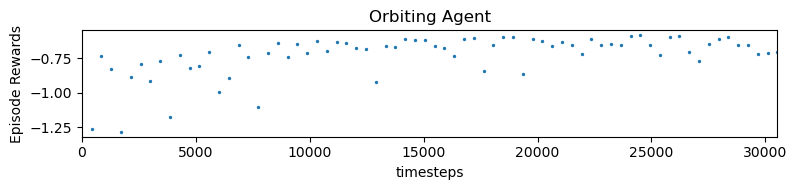

In [6]:
model = PPO(policytype, env, gamma=0.7, seed=32, verbose=0)
model.learn(total_timesteps=int(3.0e4))
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "Orbiting Agent"
)

In [1]:
tar1cov = []
tar2cov = []
def actlogprob(locals, globals):
    
        model = locals["model"]
        tar1cov.append(np.trace(model.get_env().kalman_objects[0].Pa))
        # model = locals["model"]
        
        # obs = tensor([model.get_env().env_method("get_observation")[0]])
        # logprobs = model.policy.evaluate_actions(obs, tensor([[0], [1], [2]]))[1].data

        # print(logprobs)

evaluate_policy(model, env, deterministic=False, return_episode_rewards=True, n_eval_episodes=1, callback=actlogprob)

NameError: name 'evaluate_policy' is not defined